# Лабораторная работа 3.1 Анализ и визуализация временного ряда бизнес-показателей


**Цель работы.** Освоить ключевые методы анализа временных рядов на языке Python для решения практических бизнес-задач, таких как прогнозирование, выявление трендов и сезонности в экономических показателях.

## Введение. Почему временные ряды важны для бизнеса?

Временные ряды — это наборы данных, где каждая точка привязана к определенному моменту времени. Для бизнес-информатики это один из самых ценных активов, позволяющий:

- **Прогнозировать спрос.** Оптимизировать запасы и логистику.
- **Анализировать финансовые рынки.** Предсказывать цены акций и курсы валют.
- **Оценивать эффективность маркетинга.** Отслеживать влияние рекламных кампаний на продажи во времени.
- **Планировать ресурсы.** Прогнозировать нагрузку на серверы или количество обращений в колл-центр.

В этой работе мы научимся извлекать из временных данных ценные инсайты, строить и оценивать прогнозные модели.

### Основные характеристики временных рядов

- **Тренд (Trend).** Долгосрочное направление движения ряда (рост, падение, стагнация).
- **Сезонность (Seasonality).** Периодические, повторяющиеся колебания (например, рост продаж перед Новым годом).
- **Циклы (Cycles).** Долгосрочные волнообразные колебания, не связанные с фиксированным периодом, как у сезонности (например, экономические циклы).
- **Шум (Noise/Residual).** Случайные, непрогнозируемые колебания.
- **Стационарность.** Свойство ряда, при котором его статистические характеристики (среднее, дисперсия) не меняются со временем. Большинство моделей требуют, чтобы ряд был стационарным.

## Часть 1. Подготовка к анализу

Перед началом работы установим и импортируем все необходимые библиотеки.

In [6]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn -q

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Работа с датами и временем в Pandas

Правильная работа с временными метками — основа анализа временных рядов. Pandas предоставляет мощный инструментарий для этого.

**Задание 1. Создание DataFrame и преобразование в формат даты**

Создайте DataFrame на основе предоставленных данных о продажах. Преобразуйте столбец `'Дата'` в специальный формат `datetime` с помощью `pd.to_datetime()` и выведите типы данных DataFrame с помощью `.info()`.

In [9]:
data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}

# Ваш код здесь
# 1. Создайте DataFrame 'df' из словаря 'data'
df = pd.DataFrame(data)

# 2. Преобразуйте столбец 'Дата'
df['Дата'] = pd.to_datetime(df['Дата'])

# 3. Выведите информацию о DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Дата     5 non-null      datetime64[ns]
 1   Продажи  5 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 212.0 bytes


**Задание 2. Установка временного индекса**

Для удобной работы с временными рядами столбец с датами часто устанавливают в качестве индекса DataFrame. Используйте метод `.set_index()` для установки столбца `'Дата'` в качестве индекса.

In [11]:
# Ваш код здесь
# Установите 'Дата' в качестве индекса для df
df = df.set_index('Дата')

**Задание 3. Фильтрация данных по дате**

Используя временной индекс, выберите данные о продажах за период с марта по апрель 2023 года включительно.

In [14]:
# Ваш код здесь
df.loc['2023-03':'2023-04']

,Продажи
Дата,
2023-03-01,1300
2023-04-01,1100


### Обработка пропущенных значений

Реальные бизнес-данные часто содержат пропуски. Их корректная обработка — критически важный шаг.

**Задание 4. Обнаружение пропущенных значений**

Создайте новый DataFrame `df_missing` с пропущенным значением. Используйте `.isnull().sum()` для подсчета количества пропусков в каждом столбце.

In [20]:
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                  'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

# Ваш код здесь
# Посчитайте пропущенные значения
df_missing.isnull().sum()

Продажи    1
dtype: int64

**Задание 5. Заполнение пропусков средним значением**

Заполните пропущенное значение в столбце `'Продажи'` средним значением этого же столбца. Это более robustный подход, чем заполнение нулем. Не забудьте переприсвоить результат.

In [22]:
# Ваш код здесь
# 1. Рассчитайте среднее по столбцу 'Продажи'
mean_value = df_missing['Продажи'].mean()

# 2. Заполните пропуски с помощью .fillna()
df_missing['Продажи'] = df_missing['Продажи'].fillna(mean_value)

**Задание 6. Заполнение пропусков методом интерполяции**

Интерполяция заполняет пропуски, вычисляя промежуточные значения между двумя известными точками. Это часто дает более реалистичный результат. Примените метод `.interpolate()` к `df_missing`.

In [24]:
# Ваш код здесь
df_missing = df_missing.interpolate()

## Часть 2. Исследовательский анализ временных рядов (EDA)

На этом этапе мы будем использовать реальный набор данных о ежемесячном производстве бензина в США. Наша цель — визуализировать данные и выявить их основные компоненты.

**Задание 7. Загрузка и подготовка данных**

Загрузите данные по ссылке. Убедитесь, что столбец с датой преобразован в `datetime` и установлен в качестве индекса. Выведите первые 5 строк.

In [26]:
# Ваш код здесь
gas_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_gasoline_production.csv"

# Загрузите данные, используя parse_dates=['date'] и index_col='date'
df_gas = pd.read_csv(gas_url, parse_dates=['date'], index_col='date')
df_gas.head()

,value
date,
1991-02-03,6.621
1991-02-10,6.433
1991-02-17,6.582
1991-02-24,7.224
1991-03-03,6.875


**Задание 8. Визуализация временного ряда**

Постройте линейный график для столбца `'value'`, чтобы визуально оценить данные. Добавьте заголовок и подписи осей.

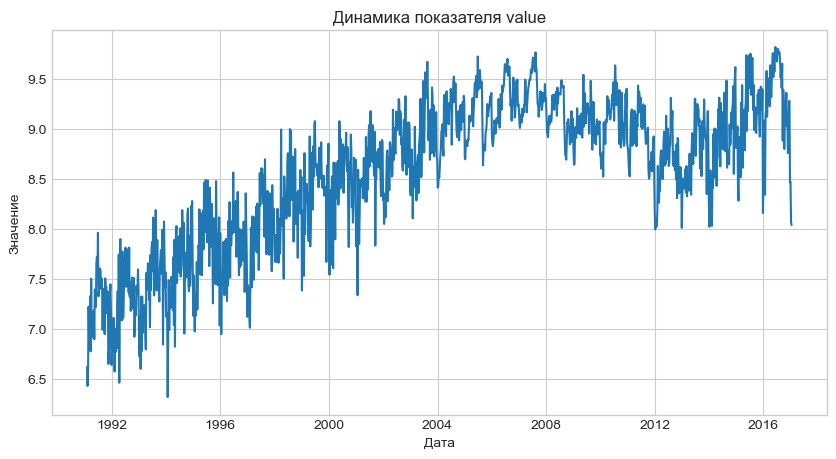

In [32]:
# Ваш код здесь
plt.figure(figsize=(10, 5))
plt.plot(df_gas['value'])
plt.title('Динамика показателя value')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(True)
plt.show()

**Задание 9. Ресэмплинг для агрегации данных**

Исходные данные имеют еженедельную частоту, что делает график 'шумным'. Преобразуйте ряд в ежемесячный (`'M'`), агрегируя значения с помощью среднего (`.mean()`). Сохраните результат в `gas_monthly` и постройте график.

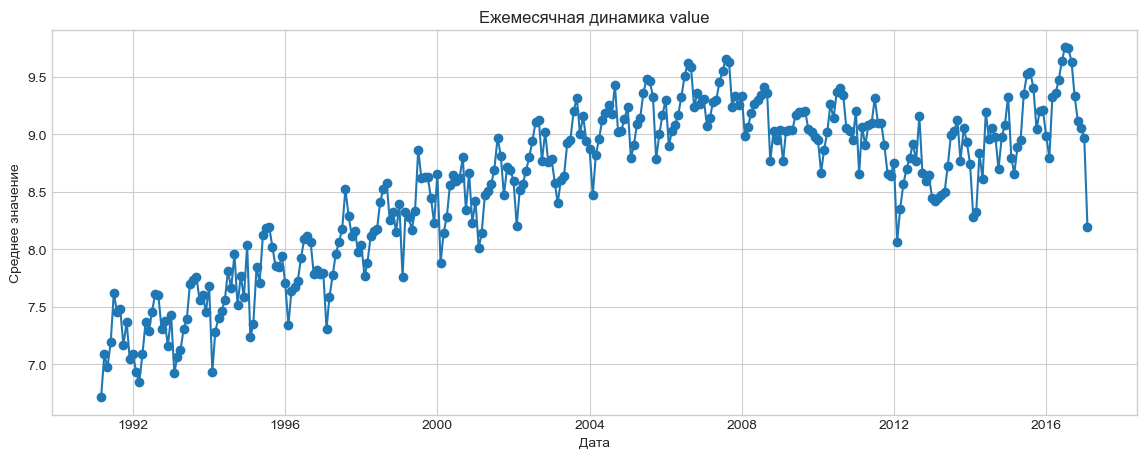

In [42]:
# Ваш код здесь
# 1. Выполните ресэмплинг
gas_monthly = df_gas.resample('ME').mean()

# 2. Постройте график для gas_monthly['value']
plt.figure(figsize=(14, 5))
plt.plot(gas_monthly['value'], marker='o')
plt.title('Ежемесячная динамика value')
plt.xlabel('Дата')
plt.ylabel('Среднее значение')
plt.grid(True)
plt.show()

**Задание 10. Сглаживание с помощью скользящего среднего**

Чтобы лучше увидеть долгосрочный тренд, примените скользящее среднее. Создайте новый столбец `'rolling_mean_12'` в `gas_monthly`, рассчитав среднее за 12 месяцев с помощью `.rolling(window=12).mean()`. Постройте на одном графике исходный ряд и сглаженный.

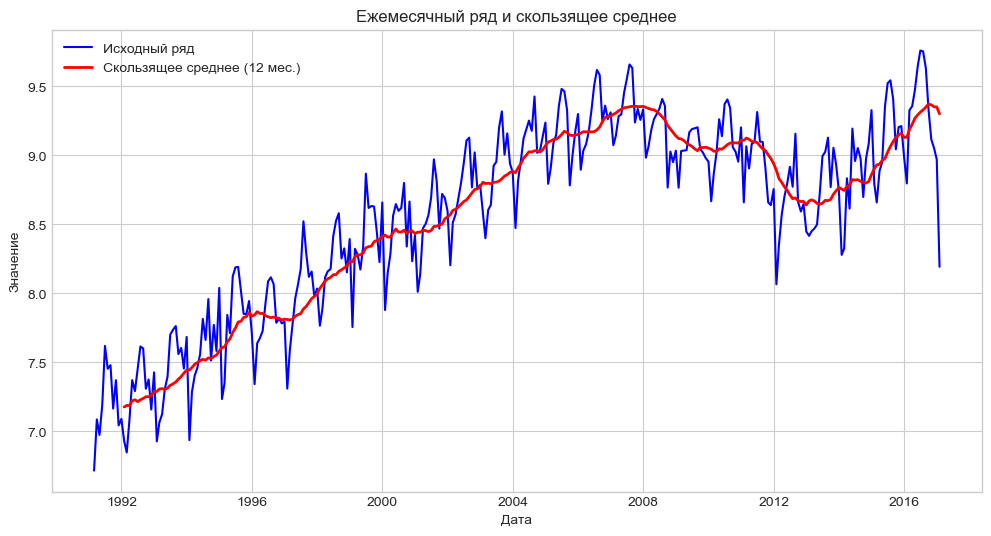

In [44]:
# Ваш код здесь
# 1. Рассчитайте скользящее среднее
gas_monthly['rolling_mean_12'] = gas_monthly['value'].rolling(window=12).mean()

# 2. Постройте оба графика
plt.figure(figsize=(12, 6))
plt.plot(gas_monthly['value'], label='Исходный ряд', color='blue')
plt.plot(gas_monthly['rolling_mean_12'], label='Скользящее среднее (12 мес.)', color='red', linewidth=2)
plt.title('Ежемесячный ряд и скользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

**Задание 11. Декомпозиция временного ряда**

Используйте `seasonal_decompose` из `statsmodels`, чтобы разложить ежемесячный ряд `gas_monthly['value']` на тренд, сезонность и остаток. Визуализируйте результат с помощью метода `.plot()`.

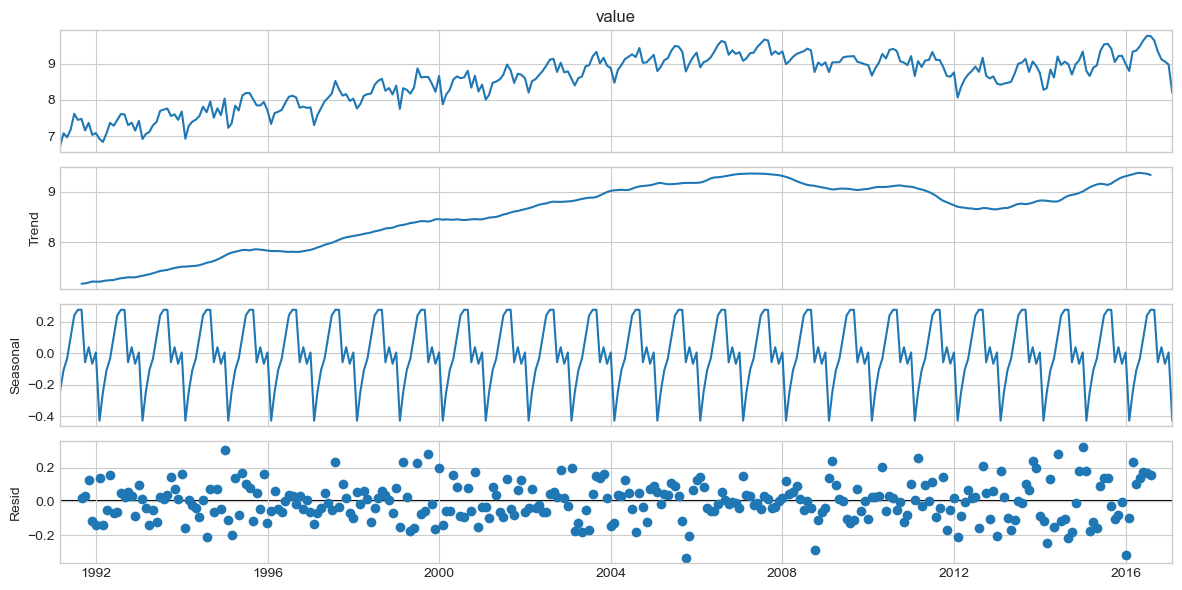

In [54]:
# Ваш код здесь
# 1. Выполните декомпозицию
decomposition = seasonal_decompose(gas_monthly['value'], model='additive', period=12)

# 2. Постройте график
decomposition.plot()
plt.show()

## Часть 3. Стационарность и корреляционный анализ

**Задание 12. Проверка на стационарность**

Проведите расширенный тест Дики-Фуллера (`adfuller`) для ряда `gas_monthly['value']`. Проанализируйте p-значение и сделайте вывод о стационарности ряда.

In [62]:
# Ваш код здесь
result = adfuller(gas_monthly['value'])

adf_statistic = result[0]
p_value = result[1]
used_lag = result[2]
n_obs = result[3]
critical_values = result[4]

print(f"\nADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print(f"Lags used: {used_lag}")
print(f"Number of observations: {n_obs}\n")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")
print()


ADF Statistic: -2.1977503103051497
p-value: 0.20706297746330277
Lags used: 16
Number of observations: 295

Critical Values:
   1%: -3.452713099849546
   5%: -2.871387839457783
   10%: -2.5720171933352485



**Задание 13. Достижение стационарности через дифференцирование**

Чтобы сделать ряд стационарным, примените к нему дифференцирование первого порядка с помощью метода `.diff()`. Удалите появившееся значение `NaN` и сохраните результат в `gas_monthly_diff`.

In [64]:
# Ваш код здесь
gas_monthly_diff = gas_monthly['value'].diff()
gas_monthly_diff = gas_monthly_diff.dropna()
gas_monthly_diff.head()

date
1991-03-31    0.37100
1991-04-30   -0.11275
1991-05-31    0.21850
1991-06-30    0.42725
1991-07-31   -0.16575
Freq: ME, Name: value, dtype: float64

**Задание 14. Повторная проверка на стационарность**

Проведите тест Дики-Фуллера для нового, дифференцированного ряда `gas_monthly_diff`. Сравните p-значение с предыдущим результатом.

In [70]:
# Ваш код здесь
result_diff = adfuller(gas_monthly_diff)

adf_statistic_diff = result_diff[0]
p_value_diff = result_diff[1]
critical_values_diff = result_diff[4]

print(f"\nADF Statistic: {adf_statistic_diff}")
print(f"p-value: {p_value_diff}\n")
print("Critical Values:")
for key, value in critical_values_diff.items():
    print(f"   {key}: {value}")
print()


ADF Statistic: -3.063922895836463
p-value: 0.02934083639628824

Critical Values:
   1%: -3.452789844280995
   5%: -2.871421512222641
   10%: -2.5720351510944512



**Задание 15. Анализ автокорреляции (ACF)**

Постройте график автокорреляционной функции (ACF) для стационарного ряда `gas_monthly_diff`. Это поможет определить порядок компоненты MA в модели ARIMA.

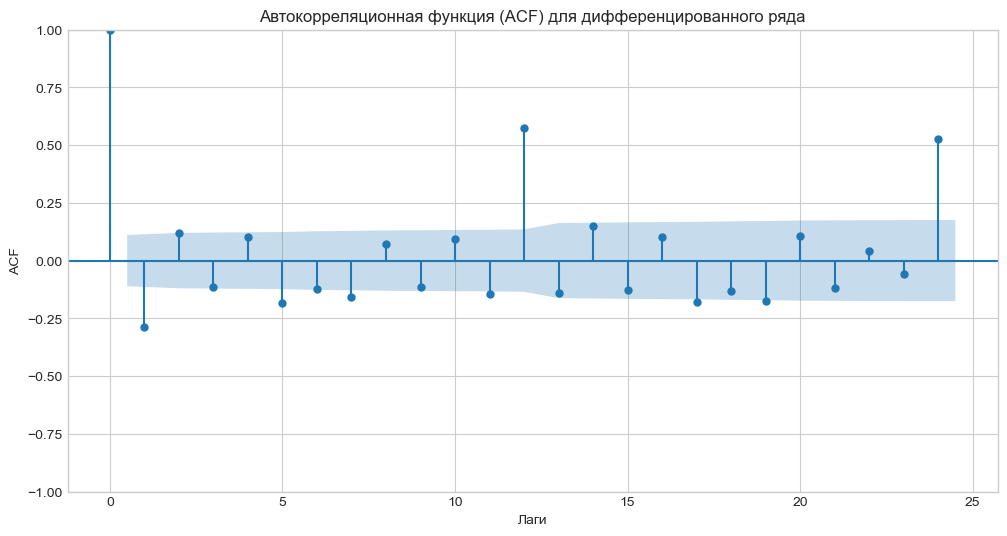

In [76]:
# Ваш код здесь

# Используйте plot_acf, передав в него ряд и ax
plot_acf(gas_monthly_diff, lags=24)
plt.title('Автокорреляционная функция (ACF) для дифференцированного ряда')
plt.xlabel('Лаги')
plt.ylabel('ACF')
plt.show()

**Задание 16. Анализ частичной автокорреляции (PACF)**

Постройте график частичной автокорреляционной функции (PACF) для `gas_monthly_diff`. Это поможет определить порядок компоненты AR в модели ARIMA.

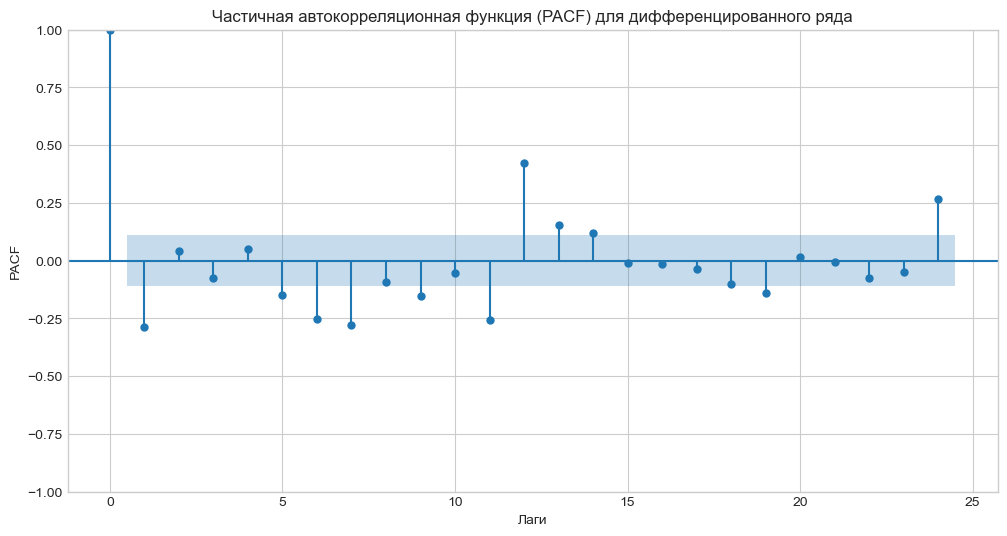

In [80]:
# Ваш код здесь

# Используйте plot_pacf, передав в него ряд и ax
plot_pacf(gas_monthly_diff, lags=24, method='ywm')
plt.title('Частичная автокорреляционная функция (PACF) для дифференцированного ряда')
plt.xlabel('Лаги')
plt.ylabel('PACF')
plt.show()

## Часть 4. Построение и оценка прогнозной модели ARIMA

Модель ARIMA (AutoRegressive Integrated Moving Average) — одна из самых популярных моделей для прогнозирования временных рядов.

- **AR (p):** Авторегрессионная часть, использующая зависимость от `p` предыдущих значений.
- **I (d):** Интегрированная часть, отвечающая за количество дифференцирований (`d`) для достижения стационарности.
- **MA (q):** Часть скользящего среднего, использующая зависимость от `q` предыдущих ошибок прогноза.

**Задание 17. Разделение данных на обучающую и тестовую выборки**

Разделите `gas_monthly['value']` на обучающую (все данные до 2015 года) и тестовую (данные с 2015 года) выборки. Это позволит нам оценить качество модели на данных, которые она не видела при обучении.

In [84]:
# Ваш код здесь
# Обучающая выборка: все данные до 2015 года (не включая 2015)
train = gas_monthly.loc[:'2014-12-31', 'value']

# Тестовая выборка: все данные с 2015 года и далее
test = gas_monthly.loc['2015-01-01':, 'value']

# Проверим размеры выборок
print(f"\nРазмер обучающей выборки: {train.shape[0]}")
print(f"Размер тестовой выборки: {test.shape[0]}\n")


Размер обучающей выборки: 287
Размер тестовой выборки: 25



**Задание 18. Обучение модели ARIMA**

Обучите модель ARIMA на обучающей выборке (`train_data`). На основе графиков ACF/PACF и того, что мы применили одно дифференцирование, выберем порядок `(p, d, q) = (2, 1, 2)`. Выведите сводку по модели с помощью `.summary()`.

In [88]:
# Ваш код здесь
# 1. Создайте модель ARIMA
import statsmodels.api as sm
model = sm.tsa.ARIMA(train, order=(2, 1, 2))

# 2. Обучите модель
model_fit = model.fit()

# 3. Выведите сводку
model_fit.summary()

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  287
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  38.581
Date:                Sat, 22 Nov 2025   AIC                            -67.163
Time:                        01:26:25   BIC                            -48.883
Sample:                    02-28-1991   HQIC                           -59.835
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4019      0.086     -4.658      0.000      -0.571      -0.233
ar.L2          0.5980      0.086      6.948      0.000       0.429       0.767
ma.L1          0.1051      0.091      1.155      0.248      -0.073       0.283
ma.L2         -0.8912      0.081    -10.970      0.000      -1.050      -0.732
sigma2         0.0441      0.004      9.978      0.000       0.035       0.053
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                10.98
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.32
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Задание 19. Построение прогноза**

Сделайте прогноз на период, соответствующий тестовой выборке. Используйте `model_fit.predict()`, указав `start` и `end` индексы тестовой выборки.

In [90]:
# Ваш код здесь
forecast = model_fit.predict(start=test.index[0], end=test.index[-1], typ='levels')
forecast

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2015-01-31    9.113623
2015-02-28    9.129190
2015-03-31    8.994427
2015-04-30    9.057903
2015-05-31    8.951796
2015-06-30    9.032405
2015-07-31    8.936549
2015-08-31    9.023284
2015-09-30    8.931097
2015-10-31    9.020022
2015-11-30    8.929148
2015-12-31    9.018854
2016-01-31    8.928451
2016-02-29    9.018435
2016-03-31    8.928203
2016-04-30    9.018285
2016-05-31    8.928115
2016-06-30    9.018230
2016-07-31    8.928084
2016-08-31    9.018210
2016-09-30    8.928074
2016-10-31    9.018201
2016-11-30    8.928072
2016-12-31    9.018198
2017-01-31    8.928071
Freq: ME, Name: predicted_mean, dtype: float64

**Задание 20. Визуализация прогноза**

Постройте график, на котором будут отображены обучающие данные, реальные тестовые данные и ваш прогноз.

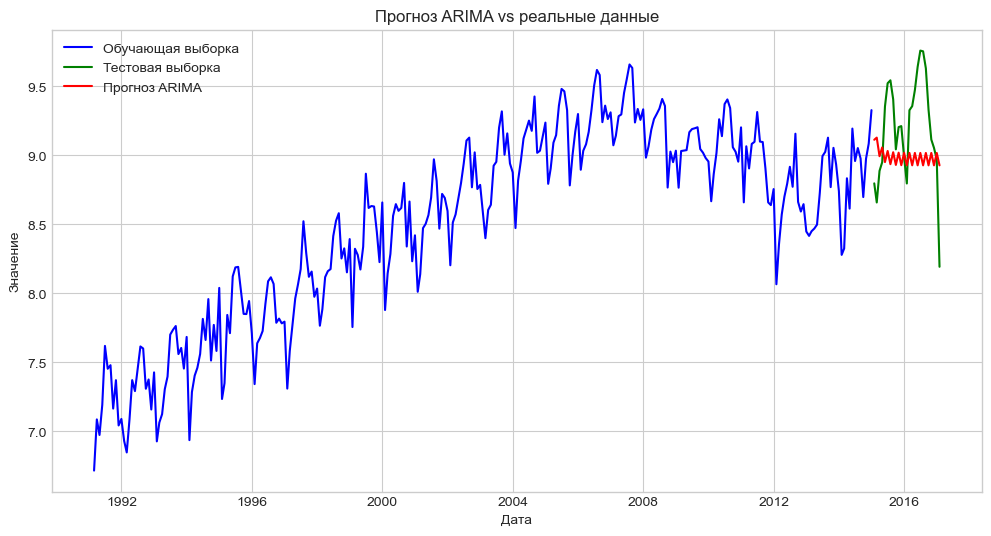

In [102]:
# Ваш код здесь

# Добавьте линию для прогноза
plt.plot(train, label='Обучающая выборка', color='blue')
plt.plot(test, label='Тестовая выборка', color='green')
plt.plot(forecast, label='Прогноз ARIMA', color='red')

plt.title('Прогноз ARIMA vs реальные данные')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

**Задание 21. Оценка качества модели**

Рассчитайте метрику RMSE (Root Mean Squared Error) для оценки точности вашего прогноза. RMSE = `sqrt(mean_squared_error(y_true, y_pred))`.

In [96]:
# Ваш код здесь
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"\nRMSE: {rmse:.2f}\n")


RMSE: 0.44



**Задание 22. Прогноз на будущее**

Теперь, когда модель оценена, используйте ее для прогнозирования на 12 месяцев вперед (за пределы имеющихся данных). Используйте метод `.forecast()`.

In [98]:
# Ваш код здесь
future_forecast = model_fit.forecast(steps=12)
future_forecast

2015-01-31    9.113623
2015-02-28    9.129190
2015-03-31    8.994427
2015-04-30    9.057903
2015-05-31    8.951796
2015-06-30    9.032405
2015-07-31    8.936549
2015-08-31    9.023284
2015-09-30    8.931097
2015-10-31    9.020022
2015-11-30    8.929148
2015-12-31    9.018854
Freq: ME, Name: predicted_mean, dtype: float64

**Задание 23. Визуализация прогноза на будущее**

Постройте график, включающий все исторические данные (`gas_monthly['value']`) и прогноз на будущее.

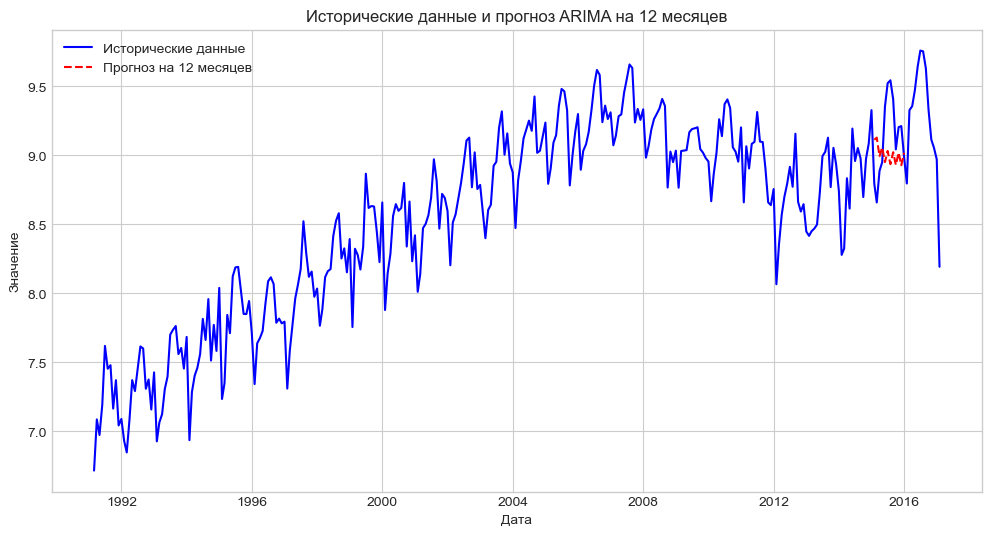

In [100]:
# Ваш код здесь

# Добавьте линию для прогноза на будущее
plt.plot(gas_monthly['value'], label='Исторические данные', color='blue')
plt.plot(future_forecast, label='Прогноз на 12 месяцев', color='red', linestyle='--')

plt.title('Исторические данные и прогноз ARIMA на 12 месяцев')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

## Часть 5. Индивидуальные задания для самостоятельной работы

**Инструкция.** Выполните задания, соответствующие вашему варианту. В качестве основного набора данных используйте `gas_monthly` (ежемесячные данные о производстве бензина) или `unemployment_df` (квартальные данные об уровне безработицы), как указано в задании. Сначала загрузим второй датасет.

In [6]:
unemployment_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_unemployment.csv"
unemployment_df = pd.read_csv(unemployment_url, parse_dates=['date'], index_col='date')
print("Данные по безработице (head):")
print(unemployment_df.head())

print("\nДанные по производству бензина (head):")
print(gas_monthly.head())

Данные по безработице (head):
            value
date             
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2

Данные по производству бензина (head):


NameError: name 'gas_monthly' is not defined

**Вариант 5:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию ряда `gas_monthly`.
3. **Преобразование:** Агрегируйте данные до квартальной частоты (`'Q'`), используя медиану.
4. **Стационарность:** Проверьте агрегированный ряд на стационарность.
5. **Прогноз:** Обучите модель ARIMA(1,1,0) на `gas_monthly` (данные до 2012) и сделайте прогноз на 6 шагов.

In [24]:
# 1. Данные: gas_monthly
gas_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_gasoline_production.csv"

df_gas = pd.read_csv(gas_url, parse_dates=['date'], index_col='date')
df_gas.head()
gas_monthly = df_gas.resample('ME').mean()
gas_monthly

,value
date,
1991-02-28,6.715000
1991-03-31,7.086000
1991-04-30,6.973250
1991-05-31,7.191750
1991-06-30,7.619000
...,...
2016-09-30,9.331500
2016-10-31,9.115200
2016-11-30,9.055000


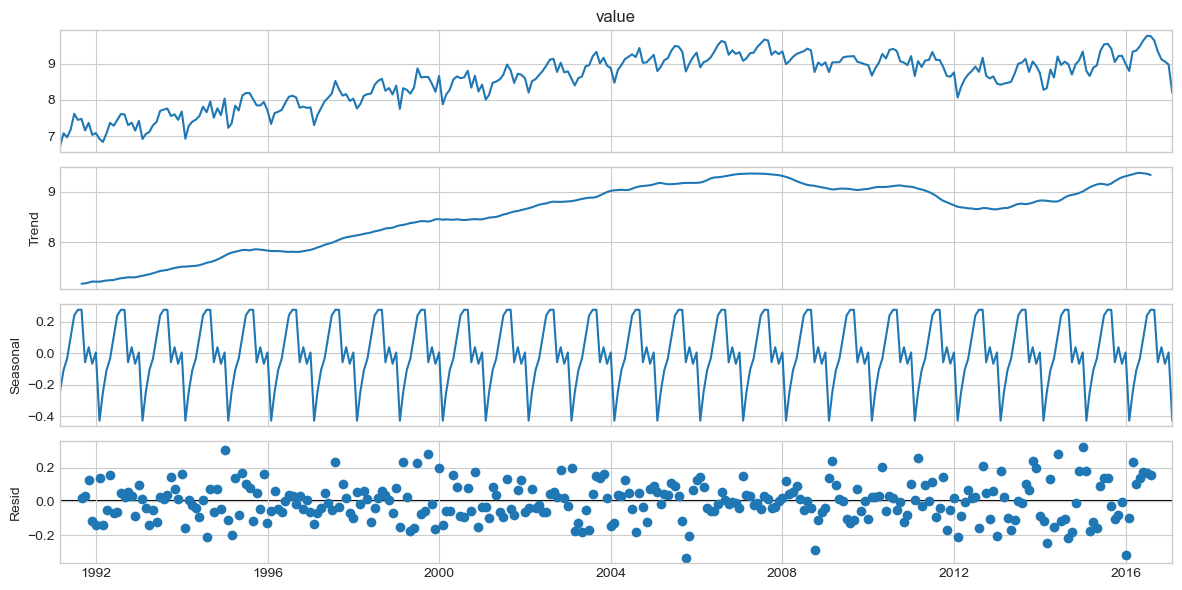

In [18]:
# 2. EDA: Проведите декомпозицию ряда gas_monthly
decomposition = seasonal_decompose(gas_monthly['value'], model='additive', period=12)

decomposition.plot()
plt.show()

In [34]:
# 3. Преобразование: Агрегируйте данные до квартальной частоты ('Q'), используя медиану.
df_q = gas_monthly.resample('Q').median()
df_q

C:\Users\User\AppData\Local\Temp\ipykernel_9364\1480851284.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_q = gas_monthly.resample('Q').median()


,value
date,
1991-03-31,6.900500
1991-06-30,7.191750
1991-09-30,7.453250
1991-12-31,7.089400
1992-03-31,6.930000
...,...
2016-03-31,9.327750
2016-06-30,9.642600
2016-09-30,9.631750


In [42]:
# 4. Стационарность: Проверьте агрегированный ряд на стационарность.
series = df_q['value'].dropna() 
result = adfuller(series)

adf_stat = result[0]
p_value  = result[1]
crit_vals = result[4]

print('\nADF statistic:', adf_stat)
print()
print('p-value:', p_value)
print()
print('Critical values:', crit_vals)
print()


ADF statistic: -2.1176966378007895

p-value: 0.23745848949712367

Critical values: {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}



In [44]:
# 5. Прогноз: Обучите модель ARIMA(1,1,0) на gas_monthly (данные до 2012) и сделайте прогноз на 6 шагов.
train = df_q.loc[:'2012-12-31', 'value']
model = ARIMA(train, order=(1, 1, 0))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   88
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  -9.163
Date:                Sun, 14 Dec 2025   AIC                             22.327
Time:                        18:04:20   BIC                             27.258
Sample:                    03-31-1991   HQIC                            24.313
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1002      0.122     -0.820      0.412      -0.340       0.139
sigma2         0.0723      0.017      4.175      0.000       0.038       0.106
Ljung-Box (L1) (Q):                   0.52   Jarque-

In [46]:
forecast = res.forecast(steps=6)
print(forecast)

2013-03-31    8.611242
2013-06-30    8.609439
2013-09-30    8.609620
2013-12-31    8.609602
2014-03-31    8.609604
2014-06-30    8.609604
Freq: QE-DEC, Name: predicted_mean, dtype: float64


---
**Вариант 1:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2005 по 2010 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 6 месяцев.
4. **Стационарность:** Примените дифференцирование первого порядка и проведите тест Дики-Фуллера.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2014 года и сделайте прогноз на 12 шагов вперед.

---
**Вариант 2:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график всего временного ряда уровня безработицы.
3. **Декомпозиция:** Разложите ряд на тренд, сезонность и остаток.
4. **Корреляция:** Постройте график ACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,0) на данных до 2010 года и сделайте прогноз на 8 кварталов вперед.

---
**Вариант 3:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 1995 по 2000 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 24 месяца.
4. **Стационарность:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,1) на данных до 2013 года и сделайте прогноз на 12 шагов.

---
**Вариант 4:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2000 года до конца.
3. **Стационарность:** Примените дифференцирование и проверьте на стационарность с помощью теста ADF.
4. **Корреляция:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2012 года, сделайте и визуализируйте прогноз на тестовом периоде (оставшиеся данные).

---
**Вариант 5:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию ряда `gas_monthly`.
3. **Преобразование:** Агрегируйте данные до квартальной частоты (`'Q'`), используя медиану.
4. **Стационарность:** Проверьте агрегированный ряд на стационарность.
5. **Прогноз:** Обучите модель ARIMA(1,1,0) на `gas_monthly` (данные до 2012) и сделайте прогноз на 6 шагов.

---
**Вариант 6:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1990 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,2) на данных до 2005 года и сделайте прогноз на 10 кварталов.

---
**Вариант 7:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за последние 5 лет (с 2012 года).
3. **Стационарность:** Примените дифференцирование второго порядка (`.diff().diff()`) и проверьте на стационарность.
4. **Корреляция:** Постройте ACF для ряда после двойного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,2,1) на данных до 2015 года и оцените её RMSE на оставшихся данных.

---
**Вариант 8:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 8 кварталов (2 года).
4. **Стационарность:** Проведите тест ADF для исходного и дифференцированного рядов, сравните результаты.
5. **Прогноз:** Обучите модель ARIMA(0,1,1) на данных до 2008 года и сделайте прогноз на 12 кварталов.

---
**Вариант 9:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему значению.
3. **Декомпозиция:** Разложите исходный ежемесячный ряд на компоненты.
4. **Корреляция:** Постройте PACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(3,1,0) на данных до 2011 года и сделайте прогноз на 18 месяцев.

---
**Вариант 10:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1970 по 1985 год.
3. **Преобразование:** Примените логарифмическое преобразование (`np.log`) к ряду и постройте его график.
4. **Стационарность:** Проверьте на стационарность логарифмированный ряд после одного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,1,2) на данных до 2000 года и сделайте прогноз на 15 кварталов.

---
**Вариант 11:**
1. **Данные:** `gas_monthly`
2. **EDA:** Рассчитайте и постройте график годового скользящего среднего (окно 12).
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите модель ARIMA(1,1,1). Выведите `.summary()`.
5. **Оценка:** Разделите данные на train/test по 2013 году. Рассчитайте RMSE прогноза на тестовой выборке.

---
**Вариант 12:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию. Проанализируйте график сезонной компоненты.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Корреляция:** Постройте ACF для остатков.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2007 года и спрогнозируйте на 10 кварталов.

---
**Вариант 13:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2010 года до конца.
3. **Преобразование:** Агрегируйте данные до 6-месячной частоты (`'6M'`) по сумме.
4. **Стационарность:** Проверьте стационарность агрегированного ряда.
5. **Прогноз:** Обучите ARIMA(0,1,2) на `gas_monthly` (данные до 2010) и сделайте прогноз на 24 месяца.

---
**Вариант 14:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график дифференцированного ряда.
3. **Корреляция:** Постройте PACF для дифференцированного ряда. Определите возможный порядок `p`.
4. **Моделирование:** Обучите модель ARIMA с порядком `p`, определённым на шаге 3, и `d=1`, `q=1`.
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед от конца имеющихся данных.

---
**Вариант 15:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию. Выведите первые 5 значений трендовой и сезонной компонент.
3. **Преобразование:** Рассчитайте процентное изменение от месяца к месяцу (`.pct_change()`) и постройте график.
4. **Стационарность:** Проверьте на стационарность ряд процентных изменений.
5. **Прогноз:** Обучите ARIMA(2,1,2) на данных до 2011 года и сделайте прогноз на 12 шагов.

---
**Вариант 16:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 2 (полгода).
3. **Корреляция:** Постройте ACF для дифференцированного ряда. Определите возможный порядок `q`.
4. **Моделирование:** Обучите модель ARIMA с порядком `q`, определённым на шаге 3, и `d=1`, `p=1`.
5. **Оценка:** Разделите данные по 2009 году. Рассчитайте RMSE модели на тестовой выборке.

---
**Вариант 17:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2008 по 2012 год.
3. **Декомпозиция:** Проведите декомпозицию и постройте график только для сезонной компоненты.
4. **Стационарность:** Проведите тест ADF на сезонной компоненте.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2010 года, спрогнозируйте на 12 шагов.

---
**Вариант 18:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1995 по 2005 год.
3. **Преобразование:** Рассчитайте скользящее стандартное отклонение (`.rolling(4).std()`).
4. **Корреляция:** Постройте ACF и PACF для исходного (недифференцированного) ряда.
5. **Прогноз:** Обучите ARIMA(3,1,1) на данных до 2011 года, сделайте прогноз на 8 кварталов.

---
**Вариант 19:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до годовой частоты по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,2) на данных до 2014 года.
5. **Прогноз:** Сделайте и визуализируйте прогноз на оставшихся данных (тестовый период).

---
**Вариант 20:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график исходных данных и наложите на него скользящее среднее с окном 10.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Моделирование:** Обучите модель ARIMA(2,1,3) на данных до 2006 года.
5. **Прогноз:** Сделайте прогноз на 12 кварталов вперед.

---
**Вариант 21:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте данные за 2000-2004 гг.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 18 месяцев.
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,0) на данных до 2013 года, спрогнозируйте на 15 месяцев.

---
**Вариант 22:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Стационарность:** Проведите тест ADF на трендовой компоненте.
4. **Моделирование:** Обучите модель ARIMA(0,1,2) на данных до 2011 года.
5. **Оценка:** Сделайте прогноз на тестовом периоде (остальные данные) и рассчитайте RMSE.

---
**Вариант 23:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до квартальной частоты (`'Q'`) по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для этого агрегированного ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на агрегированном ряде (до 2014 года).
5. **Прогноз:** Сделайте прогноз на 4 квартала вперед.

---
**Вариант 24:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1985 по 1995 год.
3. **Преобразование:** Рассчитайте скользящую медиану с окном 3 (`.rolling(3).median()`).
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2004 года и сделайте прогноз на 8 кварталов.

---
**Вариант 25:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте остатки (residuals) после декомпозиции.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите модель ARIMA(3,1,2) на данных до 2012 года.
5. **Прогноз:** Сделайте прогноз на 10 месяцев вперед.

---
**Вариант 26:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему.
3. **Корреляция:** Постройте ACF для годового ряда.
4. **Моделирование:** Обучите ARIMA(1,1,0) на годовом ряде (до 2010 года).
5. **Прогноз:** Сделайте прогноз на 5 лет вперед.

---
**Вариант 27:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график скользящего среднего с окном 3 месяца.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,0) на данных до 2013 года.
5. **Оценка:** Рассчитайте RMSE модели на тестовом периоде (данные с 2013 года).

---
**Вариант 28:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2005 года до конца.
3. **Декомпозиция:** Проведите декомпозицию и постройте график трендовой компоненты.
4. **Стационарность:** Проведите тест ADF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2009 года и сделайте прогноз на 8 кварталов.

---
**Вариант 29:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за первые 10 лет (до 2001 года).
3. **Преобразование:** Рассчитайте логарифм ряда и примените к нему дифференцирование.
4. **Корреляция:** Постройте PACF для этого преобразованного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,2) на исходных данных до 2010 года и сделайте прогноз на 12 шагов.

---
**Вариант 30:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите ARIMA(2,1,2) на данных до 2012 года.
5. **Прогноз:** Визуализируйте прогноз на тестовом периоде и рассчитайте RMSE.

---
**Вариант 31:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график ряда, агрегированного до квартальной частоты по медиане.
3. **Стационарность:** Проведите тест ADF для этого квартального ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на квартальном ряде (до 2012 года).
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед.

---
**Вариант 32:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 5.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,1) на данных до 2007 года.
5. **Прогноз:** Сделайте прогноз на 10 кварталов.

---
**Вариант 33:**
1. **Данные:** `gas_monthly`
2. **EDA:** Декомпозируйте ряд. Постройте график остатков.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите ARIMA(2,1,3) на данных до 2015 года.
5. **Прогноз:** Сделайте прогноз на 12 месяцев вперед.

---
**Вариант 34:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1999 по 2009 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 6.
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(3,1,0) на данных до 2010 года и спрогнозируйте на 8 кварталов.

---
**Вариант 35:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1980 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для ряда, дифференцированного дважды (`.diff().diff()`).
5. **Прогноз:** Обучите модель ARIMA(2,2,2) на данных до 2008 года и спрогнозируйте следующие 10 кварталов.


In [ ]:
# Поле для выполнения индивидуального задания
# Пример выполнения для Варианта 1, Задание 2:
# gas_monthly['value']['2005':'2010'].plot()
# plt.title('Производство бензина с 2005 по 2010 год')
# plt.show()
